# **Finding Lane Lines on the Road** 

In [22]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [23]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        return img
    
    # filter horizontal lines
    filtered_lines = []
    for line_list in lines:
        for line in line_list:
            slope = _calc_slope(line)
            if slope is not None and 0.5 < abs(slope) < 2.0:
                filtered_lines.append(line)

    # separate line segments into right and left
    left_lines = []
    right_lines = []
    for line in filtered_lines:
        slope = _calc_slope(line)
        if slope > 0.:
            right_lines.append(line)
        else:
            left_lines.append(line)

    # calculate average of line segments
    right_line = _average_lines(right_lines, img.shape)
    left_line = _average_lines(left_lines, img.shape)
    for a_line in [left_line, right_line]:
       if a_line is None:
           continue
       x1, y1, x2, y2 = a_line
       cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
        
def _calc_slope(line):
    x1,y1,x2,y2 = line
    if x2 == x1:  # devide by zero
        return None
    else:
        return (y2-y1)/(x2-x1)
    

def _calc_length(line):
    """ Calculates length of line segment"""
    x1,y1,x2,y2 = line
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)
    
    
def _calc_intercept(line, slope):
    """ Calculates the intercept of line cy = slope * cx + intercept 
        where cx, cy in the center of the line
    """
    x1,y1,x2,y2 = line
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    return cy - slope * cx
    
    
# average lines (line length as weight)
def _average_lines(lines, img_shape):
    """ Calculate the weighted average of lines
        and extrapolate line to bottom of image
    """
    if lines is None or len(lines) == 0:
        return None
    
    weights = [_calc_length(l) for l in lines]        
    slopes = [_calc_slope(l) for l in lines]
    weighted_slope_sum = np.inner(slopes, weights)
    avg_slope = weighted_slope_sum/sum(weights)
    intercepts = [_calc_intercept(l, avg_slope) for l in lines]
    weighted_intercepts_sum = np.inner(intercepts, weights)
    avg_intercept = weighted_intercepts_sum/sum(weights)

    # now we have our line y = avg_slope * x + avg_intercept
    # we extrapolate our line to botton of image (y=540)
    # and no more upper than region of interest (y=310)
    width, height, depth = img_shape
    y1 = width * 0.65
    x1 = (y1 - avg_intercept) / avg_slope
    y2 = width
    x2 = (y2 - avg_intercept) / avg_slope
    
    return int(x1), int(y1), int(x2), int(y2)    

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def color_of_interest(img, rgb_lower, rgb_upper):
    """ Allow white and yello lane lines to pass 
    """
    
    #defining a blank mask to start with
    color_select = np.copy(img)
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    mask = cv2.inRange(img, rgb_lower, rgb_upper)
    mask = (mask == 255)
    color_select[~mask] = [0, 0, 0]
    return color_select


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [24]:
import os
image_names = os.listdir("test_images/")
for image_name in image_names:
    print(image_name)

solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


run your solution on all test_images and make copies into the test_images directory).

image saved to  out_test_images/solidWhiteCurve.jpg
image saved to  out_test_images/solidWhiteRight.jpg
image saved to  out_test_images/solidYellowCurve.jpg
image saved to  out_test_images/solidYellowCurve2.jpg
image saved to  out_test_images/solidYellowLeft.jpg
image saved to  out_test_images/whiteCarLaneSwitch.jpg


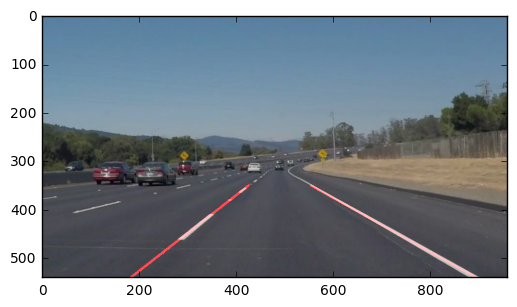

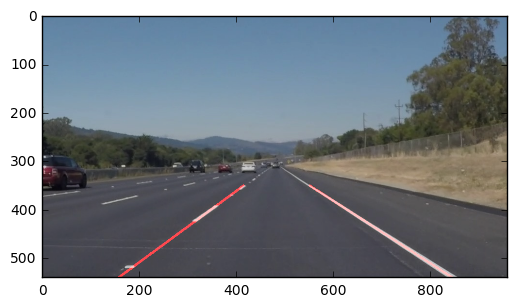

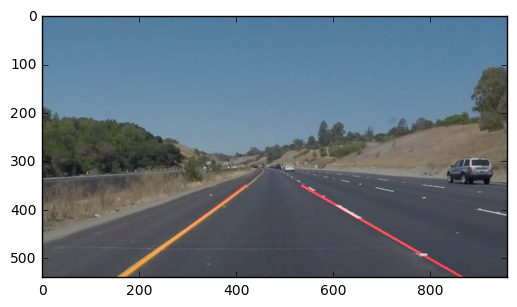

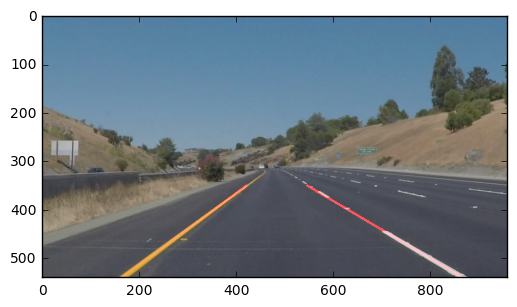

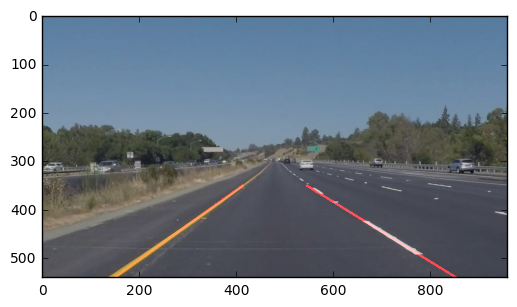

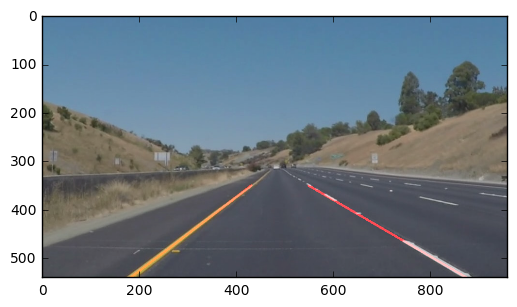

In [34]:
for image_name in image_names:
    image_path = 'test_images/' + image_name
    origin_image = mpimg.imread(image_path)
    
    rgb_lower = np.array([170, 170, 80])
    rgb_upper = np.array([255, 255, 255])
    vertices = np.array(
        [[(460,310),(500, 310), (900, 540), (60, 540)]], 
        dtype=np.int32)
    kernal_size = 11
    low_threshold = 50
    high_threshold = 100
    rho = 1
    theta = np.pi / 360.
    threshold = 10  # min num of votes
    min_line_len = 15
    max_line_gap = 1

    # color selection: 
    # let white and yello line pass throught this filter
    image = np.copy(origin_image)
    image = color_of_interest(image, rgb_lower, rgb_upper)
    image = region_of_interest(image, vertices)
    image = grayscale(image)
    image = gaussian_blur(image, kernal_size)
    image = canny(image, low_threshold, high_threshold)
    image = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    image = weighted_img(image, origin_image)
    out_path = 'out_' + image_path
    plt.imsave(out_path, image)
    print('image saved to ', out_path)
    plt.figure()
    plt.imshow(image)
    
# results are saved to out_test_images directory


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
def process_image(origin_image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    image = np.copy(origin_image)
    image = color_of_interest(image, rgb_lower, rgb_upper)
    h, w, _ = image.shape
    vertices = np.array(
        [[(0.48 * w, 0.58 * h),
          (0.52 * w, 0.58 * h), 
          (0.94 * w, h), 
          (0.06 * w, h)]], 
        dtype=np.int32)
    image = region_of_interest(image, vertices)
    image = grayscale(image)
    image = gaussian_blur(image, kernal_size)
    image = canny(image, low_threshold, high_threshold)
    image = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    image = weighted_img(image, origin_image)    
    return image

Let's try the one with the solid white lane on the right first ...

In [28]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:09<00:00, 23.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.44 s, sys: 1.37 s, total: 7.82 s
Wall time: 9.98 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [30]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:28<00:00, 27.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 20.1 s, sys: 4.69 s, total: 24.8 s
Wall time: 29.3 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


This took a lot more time than I expect, I spend about 1/4 time make my first version of lane line video, but spent rest of the time just to make it less kittery.
1. The first problem I encounter was horizontal lines in the `solidYellowLeft.mp4` so I ignored all horizontal(abs(slope) < 0.2) line segments.
2. While averaging lane lines, there are always some outliers(noise) that affect the average seriously, so I used line length as a weight to all line segments.
3. While extrapolating the lines, its hard to decide how long the line should extrapolate, so I ended up hard coding the y coordinates the line should extend.
4. I didn't managed to passed the channge Video below, I think the main reason is the shadow of tree creates a lot of edges onto the image, cause the line detection to shiver. this is definetly a weak point of my current algorithm, I think one possible way to is to let my self-driving car remember the previous believe state of lane line and use algorithms like kalman filter to avoid lines jumping. another possible way to fix this may be using some other color space to ignore brightness on the image.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [32]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:18<00:00, 13.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 12.2 s, sys: 3.38 s, total: 15.6 s
Wall time: 19.8 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))